Necessary imports

In [6]:
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score
import random
import numpy as np
import torch
from ngboost import NGBRegressor
from ngboost.scores import LogScore
from ngboost.distns import  Normal
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error
import optuna
from optuna.trial import TrialState
from scipy import stats
import pickle
import uncertainty_toolbox as uct

# check the computer name and set the path accordingly
if os.environ['COMPUTERNAME'] == 'FYNN':            # name of surface PC
    sys.path.append(r'C:\Users\Surface\Masterarbeit')
elif os.environ['COMPUTERNAME'] == 'FYNNS-PC':  # desktop name
    sys.path.append(r'C:\Users\test\Masterarbeit')
    
else:
    raise ValueError("Unbekannter Computername: " + os.environ['COMPUTERNAME'])

import data_prep

In [2]:
SEED = 42

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

Data Loading and Preprocessing to compare the algorithms, although Decision Trees are not sensitve to feature scalling, they do not use geometric distances


In [3]:
#load and transform the data, split it into training, validation, and test sets
# the split ratio is 60% training, 20% validation, and 20%
# return the feature names for later use

X_train, X_val, X_test, y_train, y_val, y_test, feature_names = data_prep.load_tranform_and_split_data('C1_V01_delta_kan', split_ratio=(0.6, 0.2, 0.2))
print(X_train.shape, X_val.shape, X_test.shape)
print(feature_names)

(31206, 37) (10402, 37) (10403, 37)
Index(['Ist_Blechhaltergewicht', 'Ist_Gegenhaltekraft_HL_1', 'T2', 'K1', 'T20',
       'K7', 'T23', 'K8', 'DS_10', 'GS_10', 'SD_10', 'LS_10', 'PP_10', 'TT_10',
       'TM5_10', 'RF_10', 'TD_10', 'is_weekend', 'dayofweek_sin',
       'dayofweek_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'quarter_sin', 'quarter_cos', 'week_sin',
       'week_cos', 'Diff_Hubzahl', 'Diff_Ziehtiefe',
       'Diff_Ziehkissenverstellu', 'Diff_Stoesselverstellung-mm',
       'Diff_Gewichtsausgleich', 'BT_NR_freq', 'STP_NR_freq'],
      dtype='object')


NGBoost for outputting Probalitiy Distribution instead of single value https://stanfordmlgroup.github.io/ngboost/1-useage.html

Optuna Hyperparameter Search

In [5]:
def objective(trial):

    set_seed(SEED)  # Set the seed for reproducibility
    # Define the hyperparameters to tune
    n_estimators = trial.suggest_int("n_estimators", 50, 1000, step = 50)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2,log=True)
    max_depth = trial.suggest_int("max_depth", 4, 20)
    
    # Create the NGBRegressor model with the suggested hyperparameters
    ngb = NGBRegressor(
        Dist=Normal, 
        Score=LogScore, 
        Base=DecisionTreeRegressor(criterion='friedman_mse', max_depth=max_depth),
        verbose=False, 
        n_estimators=n_estimators, 
        learning_rate=learning_rate
    )
    
    # Fit the model to the training data
    ngb.fit(X_train, y_train, X_val=X_val, Y_val=y_val, early_stopping_rounds=20)
    
    # Make predictions on the validation set
    y_preds = ngb.predict(X_val)
    y_dists = ngb.pred_dist(X_val)
    
    # Calculate the negative log likelihood
    nll = -y_dists.logpdf(y_val).mean()
    rmse = root_mean_squared_error(y_val, y_preds)
    print(f"Trial {trial.number}: NLL={nll}, RMSE={rmse}")
    
    return nll

In [ ]:
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed = SEED),  # Use TPE sampler for hyperparameter optimization
    pruner=optuna.pruners.MedianPruner(        
        n_startup_trials=20,                                    # Number of trials to run before pruning starts
        n_warmup_steps=5                                        # Number of warmup steps before pruning starts
    )
)
study.optimize(objective, n_trials=200, timeout=None, n_jobs=1, show_progress_bar=True)

print(study.best_params)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [8]:
ngb = NGBRegressor(Dist=Normal, 
                   Score = LogScore, 
                   Base = DecisionTreeRegressor(criterion='friedman_mse' , max_depth=9), 
                   verbose = True, 
                   n_estimators=750, 
                   learning_rate=0.003)
ngb.fit(X_train, y_train, X_val=X_val, Y_val=y_val, early_stopping_rounds=20)

[iter 0] loss=3.4547 val_loss=3.4396 scale=1.0000 norm=6.1507
[iter 100] loss=3.1449 val_loss=3.1453 scale=2.0000 norm=9.0407
[iter 200] loss=2.8878 val_loss=2.9016 scale=2.0000 norm=6.3056
[iter 300] loss=2.6755 val_loss=2.7081 scale=2.0000 norm=4.9601
[iter 400] loss=2.4967 val_loss=2.5563 scale=2.0000 norm=4.3045
[iter 500] loss=2.3492 val_loss=2.4465 scale=2.0000 norm=3.9612
[iter 600] loss=2.2332 val_loss=2.3784 scale=2.0000 norm=3.7647
[iter 700] loss=2.1438 val_loss=2.3467 scale=2.0000 norm=3.6237


,Dist,<class 'ngboo...ormal.Normal'>
,Score,<class 'ngboo...res.LogScore'>
,Base,"DecisionTreeR..., max_depth=9)"
,natural_gradient,True
,n_estimators,750
,learning_rate,0.003
,minibatch_frac,1.0
,col_sample,1.0
,verbose,True
,random_state,RandomState(M... 0x1BBB0F6B840
,validation_fraction,0.1


Eigene Implementierung für Coverage und MPIW

In [4]:
def evaluate_intervals(y_pred: np.ndarray,
                       y_std: np.ndarray,
                       y_true: np.ndarray,
                       coverage: float = 0.95):
    """
    calculate Coverage (PICP) and Mean Prediction Interval Width (MPIW)
    for a custom confidence level, based on the normal assumption.

    Args:
        y_pred : 1D array with mean predictions
        y_std  : 1D array with prediction standard deviations
        y_true : 1D array with true values
        coverage : desired confidence level (default: 0.95)

    Returns:
        dict with {'coverage': PICP, 'MPIW': MPIW, 'lower': y_lower, 'upper': y_upper}
    """
    assert y_pred.shape == y_std.shape == y_true.shape
    if np.any(y_std <= 0):
        raise ValueError("y_std must be strictly positive")

    #  quantile for the standard normal distribution
    alpha = 1 - coverage
    z = stats.norm.ppf(1 - alpha/2)  # z-value for upper bound, e.g. 1.96 for 95%

    # Calculate intervals
    y_lower = y_pred - z * y_std
    y_upper = y_pred + z * y_std

    # Coverage (PICP)
    in_interval = (y_true >= y_lower) & (y_true <= y_upper)
    picp = np.mean(in_interval)

    # MPIW
    mpiw = np.mean(y_upper - y_lower)

    return {
        "coverage": picp,
        "MPIW": mpiw,
        "lower": y_lower,
        "upper": y_upper
    }


Using Uncertainty Toolbox to get metrices

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.993
  RMSE          2.743
  MDAE          1.536
  MARPD         1.738
  R2            0.868
  Correlation   0.932
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.017
  Mean-absolute Calibration Error       0.016
  Miscalibration Area                   0.016
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.028
     Group Size: 0.56 -- Calibration Error: 0.019
     Group Size: 1.00 -- Calibration Error: 0.016
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.032
     Group Size: 0.56 -- Calibration Error: 0.022
     Group Size: 1.00 -- Calibration Error: 0.017
================

<Axes: title={'center': 'Adversarial Group Calibration'}, xlabel='Group size', ylabel='Calibration Error of Worst Group'>

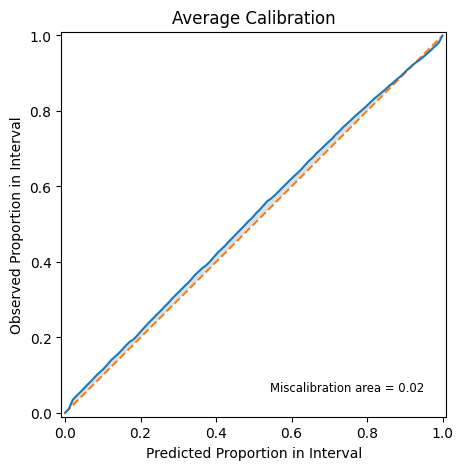

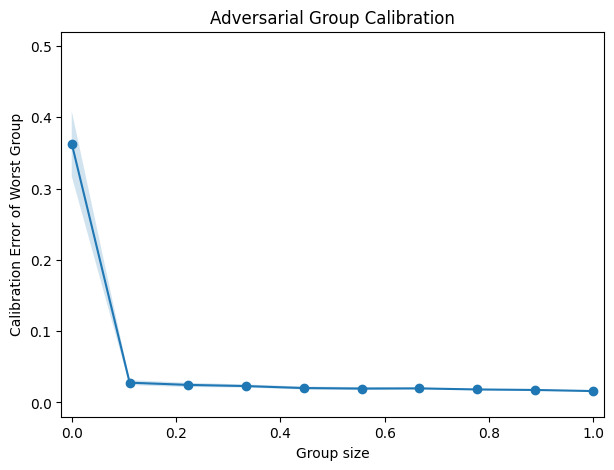

In [19]:


y_test_preds = ngb.predict(X_test)
y_test_dists = ngb.pred_dist(X_test)
# Extract standard deviation from test predictions
test_stddev = y_test_dists.scale

# Calculate and print all metrics inclunding RMSE, MAE, R²-Score, NLL, CRPS
pnn_metrics = uct.metrics.get_all_metrics( y_test_preds, test_stddev,y_test)
print(pnn_metrics)
print(pnn_metrics['accuracy']['rmse'])
# Calculate coverage for 95% confidence interval
coverage_95 = uct.metrics_calibration.get_proportion_in_interval(y_test_preds, test_stddev, y_test, quantile = 0.95 )
print(f"Coverage 95%: {coverage_95}")

# use own function to calculate coverage and MPIW
ev_intervals = evaluate_intervals(y_test_preds, test_stddev, y_test, coverage=0.95)
print(f'coverage: {ev_intervals["coverage"]}, MPIW: {ev_intervals["MPIW"]}')

# calibration Curve with UCT
uct.viz.plot_calibration(y_test_preds, test_stddev, y_test)

# adversarial group calibration
uct.viz.plot_adversarial_group_calibration(y_test_preds, test_stddev, y_test)

Do 10 Runs for a more representative Study

In [7]:
number_of_runs = 10
result = {}

ngb_path = r"C:\Users\test\Masterarbeit\models\Modelsaves\NGBoost"
ngb_result_path = r"C:\Users\test\Masterarbeit\models\Modelresults\NGBoost"

for run in range(number_of_runs):

    model_name = f'ngboost_run_{run+1}.pkl'
    # choose a random seed for each run
    seed = random.randint(0, 10000)
    print(f"Run {run+1}/{number_of_runs} with seed {seed}")
    set_seed(seed)

    ngb = NGBRegressor(Dist=Normal, 
                   Score = LogScore, 
                   Base = DecisionTreeRegressor(criterion='friedman_mse' , max_depth=9), 
                   verbose = True, 
                   n_estimators=750, 
                   learning_rate=0.003)
    # Train and evaluate the model
    ngb.fit(X_train, y_train, X_val=X_val, Y_val=y_val, early_stopping_rounds=20)

    pickle.dump(ngb, open(os.path.join(ngb_path, model_name), "wb"))

    y_test_preds = ngb.predict(X_test)
    y_test_dists = ngb.pred_dist(X_test)
    # Extract standard deviation from test predictions
    test_stddev = y_test_dists.scale

    # Calculate and print all metrics inclunding RMSE, MAE, R²-Score, NLL, CRPS
    pnn_metrics = uct.metrics.get_all_metrics( y_test_preds, test_stddev,y_test)
    print(pnn_metrics)

   # use own function to calculate coverage and MPIW
    ev_intervals = evaluate_intervals(y_test_preds, test_stddev, y_test, coverage=0.95)
    print(f'coverage: {ev_intervals["coverage"]}, MPIW: {ev_intervals["MPIW"]}')

    results_per_run = {
    'mean_prediction': y_test_preds,
    'std_prediction' : test_stddev,
    'coverage': ev_intervals["coverage"],
    'MPIW': ev_intervals["MPIW"],
    'RMSE': pnn_metrics['accuracy']['rmse'],
    'MAE': pnn_metrics['accuracy']['mae'],
    'R2': pnn_metrics['accuracy']['r2'],
    'NLL': pnn_metrics['scoring_rule']['nll'],
    'CRPS': pnn_metrics['scoring_rule']['crps']
    }

    result[f'run_{run+1}'] = results_per_run

with open(ngb_result_path, 'wb') as f:
    pickle.dump(result, f)    

Run 1/10 with seed 3745
[iter 0] loss=3.4547 val_loss=3.4396 scale=1.0000 norm=6.1507
[iter 100] loss=3.1449 val_loss=3.1453 scale=2.0000 norm=9.0407
[iter 200] loss=2.8878 val_loss=2.9017 scale=2.0000 norm=6.3056
[iter 300] loss=2.6755 val_loss=2.7082 scale=2.0000 norm=4.9601
[iter 400] loss=2.4966 val_loss=2.5563 scale=2.0000 norm=4.3044
[iter 500] loss=2.3492 val_loss=2.4466 scale=2.0000 norm=3.9614
[iter 600] loss=2.2331 val_loss=2.3787 scale=2.0000 norm=3.7638
[iter 700] loss=2.1440 val_loss=2.3476 scale=2.0000 norm=3.6241


KeyboardInterrupt: 

nll_train: 2.109
Train MSE: 2.228
R² on Train Data: 0.915
nll_test: 2.330
Test MSE: 2.742
R² on Test Data: 0.868
Number of true values within the confidence interval: 9862 out of 10403
Coverage: 94.80%


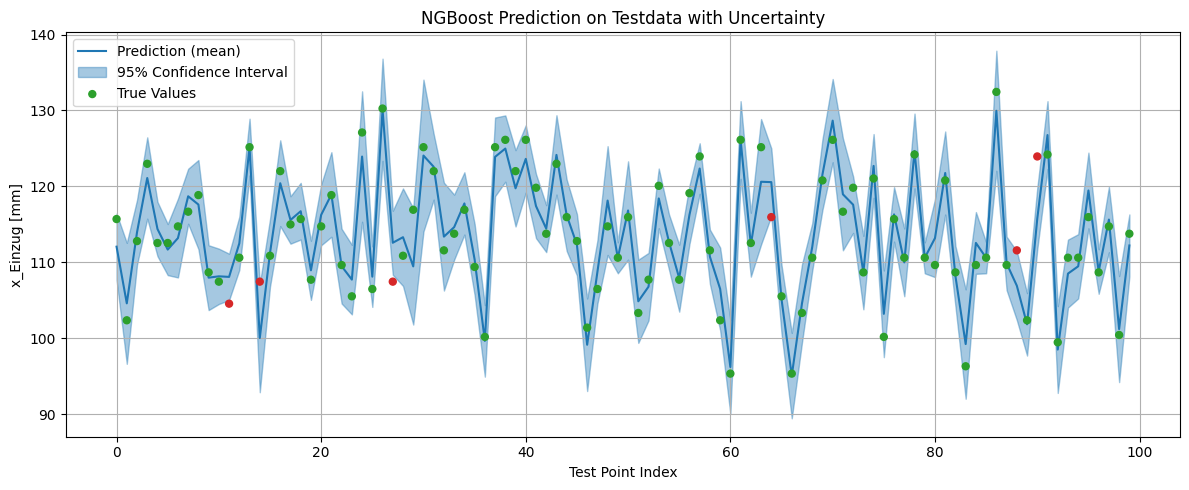

In [14]:
#! handling the train data
# Predicte mean and distribution for train and test data
y_train_preds = ngb.predict(X_train)
y_train_dists = ngb.pred_dist(X_train)

# print the negative log likelihood
print(f"nll_train: {-y_train_dists.logpdf(y_train).mean():.3f}")
# calculate the mean squared error
mse_train = root_mean_squared_error(y_train, y_train_preds)
print(f"Train MSE: {mse_train:.3f}")
# Calculate R² for the train data
r2_train = r2_score(y_train, y_train_preds)
print(f"R² on Train Data: {r2_train:.3f}")


#! handling the test data
# Select a random subset of test data for visualization
num_points = 100
np.random.seed(42)

random_indices = np.random.choice(len(X_test), num_points, replace=False)
random_indices.sort()

# Predict mean and distribution for test data
y_test_preds = ngb.predict(X_test)
y_test_dists = ngb.pred_dist(X_test)
# Extract standard deviation from test predictions
test_stddev = y_test_dists.scale

# print the negative log likelihood
print(f"nll_test: {-y_test_dists.logpdf(y_test).mean():.3f}")
# calculate the mean squared error
mse_test = root_mean_squared_error(y_test, y_test_preds)
print(f"Test MSE: {mse_test:.3f}")
# Calculate R² for the test data
r2_test = r2_score(y_test, y_test_preds)
print(f"R² on Test Data: {r2_test:.3f}")

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
ngboost_lower = y_test_preds - 2*test_stddev
ngboost_upper = y_test_preds + 2*test_stddev

# calculate the coverage of the confidence interval
in_interval = (y_test >= ngboost_lower) & (y_test <= ngboost_upper)
# number of true
counter = 0
# Print whether each true value is within the confidence interval
for i in in_interval:
    if i:
        counter += 1

print(f"Number of true values within the confidence interval: {counter} out of {len(in_interval)}")

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Check whether each true value of the random indices lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval_rand_indi = (y_test[random_indices] >= ngboost_lower[random_indices]) & (y_test[random_indices] <= ngboost_upper[random_indices])
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval_rand_indi]

# Plotting the prediction with uncertainty and true values
fig = plt.figure(figsize=(12, 5))
x_axis = np.arange(num_points)

# Plot predicted mean
plt.plot(x_axis, y_test_preds[random_indices], label="Prediction (mean)", color='tab:blue')

# Shade the 95% confidence interval (±2 standard deviations)
plt.fill_between(x_axis, ngboost_lower[random_indices], ngboost_upper[random_indices],
                 alpha=0.4, color='tab:blue', label='95% Confidence Interval')

# Plot true target values as orange dots
plt.scatter(x_axis, y_test[random_indices], label="True Values", c=colors, s=25, zorder=3)

# Add plot labels and formatting
plt.title("NGBoost Prediction on Testdata with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# wandb.init(project="ngboost-fem-rauschen", config={
#     "n_estimators": 400,
#     "learning_rate": 0.01,
#     "distribution": "Normal",
#     "score": "LogScore",
#     "early_stopping_rounds": 2,
#     })

# wandb.log({"coverage": coverage})
# wandb.log({"R²": r2_test})
# wandb.log({"confidence_interval_plot": wandb.Image(fig)})

[6873 5130 6255 ...  402 3043 1975]
[ 65.      81.7435  83.9345 ... 127.3499 127.3499 127.3499]
[ 88.78584213  92.92870154 113.33160046 ... 121.46279274 122.70899614
 121.63707935]
Lowest lower bound: 36.16890382106944
Highest upper bound: 149.68849925757692
Highest difference between upper and lower bound: 113.51959543650747
Index of highest difference: 1


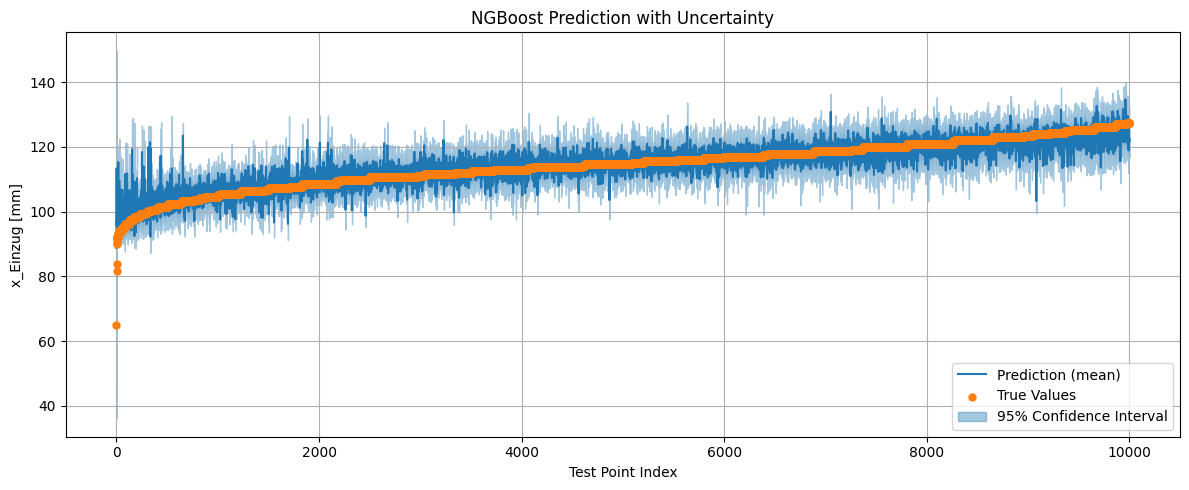

In [27]:
sort_idx = np.argsort(y_test)
print(sort_idx)
y_test_preds_sorted = y_test_preds[sort_idx]
test_stddev_sorted = test_stddev[sort_idx]
y_test_sorted = y_test[sort_idx]

n = 10000

ngb_mean_sorted = y_test_preds_sorted[:n]
ngb_std_sorted = test_stddev_sorted[:n]
y_test_sorted = y_test_sorted[:n]

print(y_test_sorted)
print(ngb_mean_sorted)
ngb_lower_bound_full = ngb_mean_sorted - 2 * ngb_std_sorted
ngb_upper_bound_full = ngb_mean_sorted + 2 * ngb_std_sorted
# print lowest of ngb_lower_bound_full and highest of ngb_upper_bound_full
print(f"Lowest lower bound: {np.min(ngb_lower_bound_full)}")
print(f"Highest upper bound: {np.max(ngb_upper_bound_full)}")

# print the highes difference between upper and lower bound and index of the highest difference
diff = ngb_upper_bound_full - ngb_lower_bound_full
print(f"Highest difference between upper and lower bound: {np.max(diff)}")
print(f"Index of highest difference: {np.argmax(diff)}")


# Create the plot
plt.figure(figsize=(12, 5))
x_axis = np.arange(n)  # Create an index axis for plotting
# Plot the predicted mean
plt.plot(ngb_mean_sorted, label="Prediction (mean)", color='tab:blue')

# plot true values for the first 100 points
plt.scatter(x_axis, y_test_sorted, label="True Values", c='tab:orange', s=25, zorder=3)

# Plot the confidence interval as a shaded region
plt.fill_between(x_axis, ngb_lower_bound_full, ngb_upper_bound_full, alpha=0.4,
                 color='tab:blue', label='95% Confidence Interval')
# Final plot settings
plt.title("NGBoost Prediction with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Overview on the feature importance

In [ ]:
import seaborn as sns
## Feature importance for loc trees
feature_importance_loc = ngb.feature_importances_[0]

## Feature importance for scale trees
feature_importance_scale = ngb.feature_importances_[1]

#feature names baseline dataset
#['Matrizenradius [mm ]', 'Stempelkantenradius [mm]', 'Blechdicke [mm]',            'Platinenabmessung [mm]', '1/4 Niederhalterkraft [N]', 'Ziehtiefe [mm]']

df_loc = pd.DataFrame({
                        'feature':feature_names,
                        'importance':feature_importance_loc})\
                        .sort_values('importance',ascending=False)
    
df_scale = pd.DataFrame({
                        'feature':feature_names,
                        'importance':feature_importance_scale})\
                        .sort_values('importance',ascending=False)

df_loc_filtered = df_loc[df_loc['importance'] < 0.01]
df_scale_filtered = df_scale[df_scale['importance'] < 0.01]

print(df_loc_filtered)
print(df_scale_filtered)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,20))
fig.suptitle("Feature importance plot for distribution parameters", fontsize=15)
sns.barplot(x='importance',y='feature',ax=ax1,data=df_loc, color="skyblue").set_title('mean (loc param)')
sns.barplot(x='importance',y='feature',ax=ax2,data=df_scale, color="skyblue").set_title('std (scale param)')

Permutation Importance

Wie stark sinkt die Modell-Performance, wenn ein Feature zufällig durchmischt (permutiert) wird

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(ngb, X_test, y_test, n_repeats=10, random_state=42, scoring = 'neg_mean_squared_error')

sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10,6))
plt.barh(np.array(feature_names)[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Permutation Importance (NGBoost)")
plt.show()


SHAP Interpretation:
„Wie viel trägt jedes Feature zur Abweichung der Vorhersage vom Durchschnitt bei?“

Dazu berechnet SHAP für jedes Feature und jeden Datenpunkt einen Wert, den SHAP-Wert, der quantifiziert:

positiver SHAP-Wert → dieses Feature hat die Vorhersage erhöht

negativer SHAP-Wert → dieses Feature hat die Vorhersage gesenkt

In [ ]:
import shap
shap.initjs()

## SHAP plot for loc trees
explainer = shap.TreeExplainer(ngb, model_output=0) # use model_output = 1 for scale trees
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names=feature_names, max_display=10)


Eigene Loop für Grid Search, um mit einem festen Val Set zu arbeiten und dann Early Stopping implementieren, GridSearchCV nur mit Cross Validation und ohne Early Stopping möglich von sklearn

In [ ]:
# define the hyperparameter grid    
param_grid = {
    'n_estimators': [ 200, 400, 600],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [6, 8, 10, 12, 14],
}

best_score = float('inf')
best_params = None
scores = []
# Loop through all combinations of hyperparameters
for max_depth in param_grid['max_depth']:
    for n_estimators in param_grid['n_estimators']:
        for learning_rate in param_grid['learning_rate']:
            # Create a new NGBRegressor with the current hyperparameters
            ngb = NGBRegressor(
                Dist=Normal, 
                Score=LogScore, 
                Base=DecisionTreeRegressor(criterion='friedman_mse', max_depth=max_depth),
                verbose=True, 
                n_estimators=n_estimators, 
                learning_rate=learning_rate
            )
            
            # Fit the model to the training data
            ngb.fit(X_train, y_train, X_val=X_val, Y_val=y_val, early_stopping_rounds=20)
            
            # Make predictions on the validation set
            y_preds = ngb.predict(X_val)
            y_dists = ngb.pred_dist(X_val)
            
            # Calculate the mean squared error
            mse = mean_squared_error(y_val, y_preds)
            
            # Calculate R²
            r2 = r2_score(y_val, y_preds)
        
            # Calculate the negative log likelihood
            # Note: The logpdf method returns the log probability density function
            # for the predicted distribution at the given values
            nll = -y_dists.logpdf(y_val).mean()
            
            # Print the results            
            print(f"n_estimators: {n_estimators}, learning_rate: {learning_rate}, max_depth: {max_depth}, MSE: {mse:.3f}, R²: {r2:.3f}, Negative Log Likelihood: {nll:.3f}")
            
            # log the scores
            scores.append({
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'mse': mse,
                'r2': r2,
                'nll': nll
            })
            # Check if this is the best score so far
            if nll < best_score:
                best_score = nll
                best_params = {
                    'n_estimators': n_estimators,
                    'learning_rate': learning_rate,
                    'max_depth': max_depth
                }
     

In [ ]:
# get the best parameters, lists for nll, R2 and MSE
# list contains at each position a list element with the score and the parameters dictonary
negLL = []
r2_lst = []
mse = []
for s in scores:
    mse.append([s['mse'],s])
    r2_lst.append([s['r2'],s])
    negLL.append([s['nll'],s])

print(f"best negativ log likelyhood {min(negLL)}")
print(f" best R2-Score {max(r2_lst)}")
print(f" best MSE {min(mse)}")